In [14]:
from vision_util import *
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [27]:
def filter_blue_bricks(img_frame):
    frame = img_frame
    frame = blue_color_mask(frame)
    frame = remove_noise(frame) # toggle to test noise filer
    blue_brick_arr = find_bricks(frame) 
    return frame, blue_brick_arr

In [60]:
ret, cam = get_video_capture_frame('cr_45.jpg')

Blue bricks count: 3
Large brick

    coor:(285,132)    rotation:-0.0    px width:31.0    px height:29.0
Small brick

    coor:(158,123)    rotation:-63.43495178222656    px width:31.75216293334961    px height:33.541019439697266
    coor:(375,49)    rotation:-0.0    px width:52.0    px height:52.0


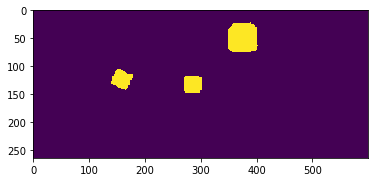

In [64]:
img = cam[75:cam.shape[0]-140, 35:cam.shape[1]-5]
img, arr = filter_blue_bricks(img)
print('Blue bricks count: {}'.format(len(arr)))
print('Large brick\n')
print('    coor:({},{})    rotation:{}    px width:{}    px height:{}'.format(arr[0].x_center, arr[0].y_center, arr[0].rotation_degrees, arr[0].pixel_width, arr[0].pixel_height))

print('Small brick\n')
print('    coor:({},{})    rotation:{}    px width:{}    px height:{}'.format(arr[1].x_center, arr[1].y_center, arr[1].rotation_degrees, arr[1].pixel_width, arr[1].pixel_height))
print('    coor:({},{})    rotation:{}    px width:{}    px height:{}'.format(arr[2].x_center, arr[2].y_center, arr[2].rotation_degrees, arr[2].pixel_width, arr[2].pixel_height))

plt.imshow(img)